In [1]:
import torch

from diffusers import FluxPipeline, FluxTransformer2DModel, GGUFQuantizationConfig
from diffusers import DiffusionPipeline

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

from llama_index.core.workflow import Event, StartEvent, StopEvent, Workflow, step, Context
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution # to visualize the Workflow

import ollama

from typing import List
from pydantic import BaseModel

import json
import os

from IPython.display import Image, display

from prompts import *

In [2]:
thumbnail_generation_settings = {
    "project_name": "project-1",
    "diffusion_model": "shuttle",
    "code_llm": "qwen2.5-coder:latest",
    "vlm": "llama3.2-vision:latest",
    "debug_mode": True
}

In [3]:
def initialize_shuttle_diffusion_pipeline():
    ckpt_path = "https://huggingface.co/shuttleai/shuttle-3.1-aesthetic/blob/main/gguf/shuttle-3.1-aesthetic-Q4_K_S.gguf"
    
    transformer = FluxTransformer2DModel.from_single_file(
        ckpt_path,
        quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    pipe = FluxPipeline.from_pretrained(
        "shuttleai/shuttle-3.1-aesthetic",
        transformer=transformer,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    return pipe

def initialize_sdxl_pipeline():

    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    ).to("cuda")
    
    return pipe
    
# Initialize the pipeline
if thumbnail_generation_settings["diffusion_model"] == "shuttle":
    pipe = initialize_shuttle_diffusion_pipeline()
else:
    pipe = initialize_sdxl_pipeline()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
def generate_image(prompt: str, file_name: str):
    """
    Generates an image based on a given prompt and saves the result under the given file name
    
    Args:
    prompt: AI generated prompt to generate an image using a diffusion model
    file_name: Name used to save the generated without file extension
    
    Returns:
    str: The whole path where the image file was saved
    """
    output_dir = "/home/ubuntu/thumbnails/" + thumbnail_generation_settings["project_name"]
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if thumbnail_generation_settings["diffusion_model"] == "shuttle":
        num_inference_steps = 4
    else:
        num_inference_steps = 50
    height = 288
    width = 512
    image = pipe(
        prompt,
        height=height,
        width=width,
        guidance_scale=10.0,
        num_inference_steps=num_inference_steps,
        generator=torch.manual_seed(42)
    ).images[0]
    file_path = output_dir + "/" + file_name + ".png"
    image.save(file_path)
    return file_path

In [5]:
def call_ollama_model(
    model="qwen2.5-coder:latest",
    system_prompt=None,
    user_prompt=None,
    temperature=0.1,
    context_size=16384,
    images=None,
    tools=None,
    json_schema=None
):
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt,
                "images": images
            }
        ],
        options={
            "temperature": temperature,
            "num_ctx": context_size
        },
        format=json_schema,
        tools=tools
    )
    
    return response.message

In [6]:
class ThumbnailIdeas(BaseModel):
    thumbnail_ideas: List[str]

class ImageSuitability(BaseModel):
    is_suitable: bool
    explanation: str

In [7]:
class ThumbnailIdeasGeneratedEvent(Event):
    thumbnail_ideas: ThumbnailIdeas

class ImagesGeneratedEvent(Event):
    image_paths: List[str]

In [8]:
class ThumbnailGenerationFlow(Workflow):
    @step
    async def generate_thumbnail_ideas(
        self, ctx: Context, ev: StartEvent
    ) -> ThumbnailIdeasGeneratedEvent:
        topic = ev.topic
        video_plan = ev.video_plan
        num_thumbnails = ev.num_thumbnails

        settings = ev.settings
        code_llm = settings.get("code_llm", "qwen2.5-coder:latest")
        vlm = settings.get("vlm", "llama3.2-vision:latest")
        debug_mode = settings.get("debug_mode", False)

        await ctx.set("code_llm", code_llm)
        await ctx.set("vlm", vlm)
        await ctx.set("debug_mode", debug_mode)

        system_prompt = "You are a professional educational YouTuber. You create content on mathematical topics. You outsource some work like thumbnail creation to freelancers. Your thumbnails contain related topics to the video content such as the bust of a greece mathematician for example. Don't make the thumbnail ideas too close to the content as this would be too abstract."
        user_prompt = "Generate a list of {num_thumbnails} thumbnail ideas on the following topic and video plan:\n\n Topic: {topic}\n\nVideo plan: {video_plan}".format(
            num_thumbnails=num_thumbnails, topic=topic, video_plan=video_plan
        )

        response_msg = call_ollama_model(
            model=vlm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            json_schema=ThumbnailIdeas.model_json_schema(),
        )

        thumbnail_ideas = json.loads(response_msg.content)

        if debug_mode:
            print(thumbnail_ideas)
            
        return ThumbnailIdeasGeneratedEvent(thumbnail_ideas=thumbnail_ideas)

    @step
    async def generate_images(
        self, ctx: Context, ev: ThumbnailIdeasGeneratedEvent
    ) -> ImagesGeneratedEvent:
        thumbnail_ideas = ev.thumbnail_ideas

        code_llm = await ctx.get("code_llm")
        debug_mode = await ctx.get("debug_mode")

        thumbnail_ideas_list = thumbnail_ideas.thumbnail_ideas
        thumbnail_ideas_str = "\n\n".join(thumbnail_ideas_list)

        system_prompt = "You are an expert prompt engineer and function calling expert and an expert prompt engineer specialized in diffusion models. You don't include instructions to generate text in your prompts."
        user_prompt = "Generate images by generating sophisticated prompts based on the following basic thumbnail ideas: {thumbnail_ideas_str}".format(
            thumbnail_ideas_str=thumbnail_ideas_str
        )

        response_msg = call_ollama_model(
            model=code_llm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            tools=[generate_image],
        )

        available_functions = {
            "generate_image": generate_image,
        }

        image_paths = []

        for tool in response_msg.tool_calls or []:
            function_to_call = available_functions.get(tool.function.name)
            if function_to_call:
                arguments = tool.function.arguments
                file_path = function_to_call(**arguments)
                image_paths.append(file_path)

                if debug_mode:
                    print("Prompt: ", arguments.get("prompt", ""))
                    print("Function output:", file_path)
                    display(Image(filename=file_path))
            else:
                print("Function not found:", tool.function.name)

        return ImagesGeneratedEvent(image_paths=image_paths)

    @step
    async def evaluate_images(
        self, ctx: Context, ev: ImagesGeneratedEvent
    ) -> StopEvent:
        image_paths = ev.image_paths
        num = await ctx.get("debug_mode")
        debug_mode = await ctx.get("debug_mode")

        system_prompt = "You are an expert YouTuber with a fine eye for good thumbnails. You want to choose the best image for your YouTube video."
        user_prompt = (
            "Evaluate if the image is suitable as a thumbnail and explain why."
        )

        for image_path in image_paths:
            response_msg = call_ollama_model(
                model="llama3.2-vision:latest",
                system_prompt=system_prompt,
                user_prompt=user_prompt,
                images=[image_path],
                temperature=0.1,
                context_size=16384,
                json_schema=ImageSuitability.model_json_schema(),
            )

            image_suitability = json.loads(response_msg.content)
            is_suitable = image_suitability.get("is_suitable", False)
            print("Thumbnail is suitable: ", str(is_suitable))
            print(image_suitability["explanation"])
            if is_suitable:
                return StopEvent(result=image_path)

        return StopEvent(result=None)

In [9]:
EXAMPLE_PLAN = """1. **Create Grid**: Draw a coordinate system on paper or screen. Mark the x and y axes for orientation. The grid should be large enough to display all given points.

2. **Mark Points**:
   - **Point A**: Locate (1, 1) on the coordinate system. Move 1 unit along the x-axis from the origin to the right and then 1 unit up along the y-axis. Mark this point as A.
   - **Point B**: Find (5, 1) on the coordinate system. Move 5 units along the x-axis from the origin to the right and stay at the same height (y=1). Mark this point as B.
   - **Point C**: Find (3, 4) on the coordinate system. Move 3 units along the x-axis from the origin to the right and then 4 units up along the y-axis. Mark this point as C.

3. **Label Points**: Label each marked point with its corresponding letter to clearly identify them: Label the point at (1, 1) as A, at (5, 1) as B, and at (3, 4) as C.

4. **Draw Lines**:
   - Connect Point A and Point B with a straight line.
   - Connect Point B and Point C with a straight line.
   - Connect Point C and Point A with a straight line.

5. **Verification**:
   - Verify that each triangle segment is drawn correctly: AB horizontal (y-coordinates equal), AC and BC diagonal in their respective directions based on their x and y coordinates.

6. **Summary**: You should now have a closed triangle, labeled with A(1, 1), B(5, 1), and C(3, 4), within your coordinate system."""

In [10]:
thumbnail_generation_flow = ThumbnailGenerationFlow(timeout=None, verbose=True)

thumbnail_generation_ctx = Context(thumbnail_generation_flow)

draw_all_possible_flows(ThumbnailGenerationFlow, filename="thumbnail_generation_flow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.ImagesGeneratedEvent'>
<class '__main__.ThumbnailIdeasGeneratedEvent'>
thumbnail_generation_flow.html


Running step generate_thumbnail_ideas
{'thumbnail_ideas': ["A stylized illustration of an ancient Greek temple with the words 'Unlocking Ancient Secrets' written in a curved line above it.", 'An image of a geometric puzzle piece with the Pythagorean Theorem formula etched into it, surrounded by faint grid lines and mathematical symbols.', 'A minimalist design featuring a compass and straightedge on a wooden desk, with a faint outline of a triangle in the background.']}
Step generate_thumbnail_ideas produced event ThumbnailIdeasGeneratedEvent
Running step generate_images


  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A stylized illustration of an ancient Greek temple with the words 'Unlocking Ancient Secrets' written in a curved line above it.
Function output: /home/ubuntu/thumbnails/project-1/ancient_temple.png


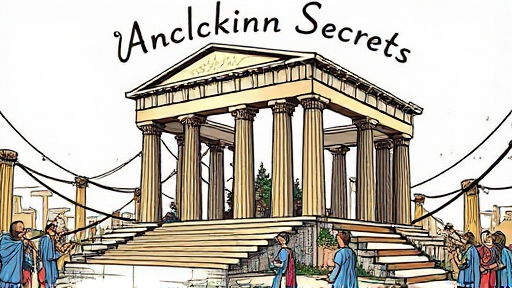

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  An image of a geometric puzzle piece with the Pythagorean Theorem formula etched into it, surrounded by faint grid lines and mathematical symbols.
Function output: /home/ubuntu/thumbnails/project-1/pythagorean_theorem_piece.png


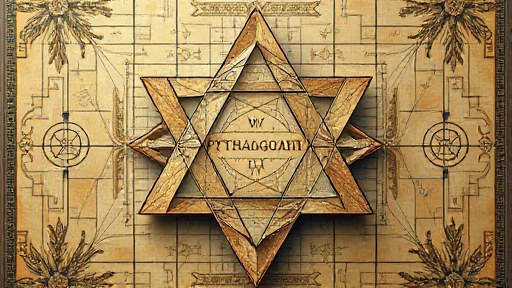

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A minimalist design featuring a compass and straightedge on a wooden desk, with a faint outline of a triangle in the background.
Function output: /home/ubuntu/thumbnails/project-1/minimalist_design.png


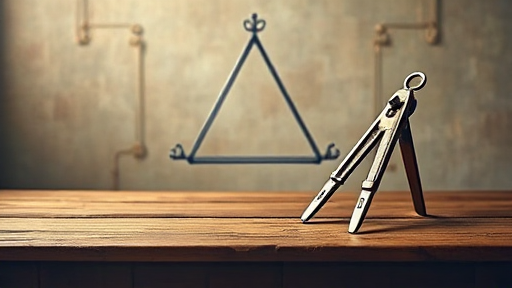

Step generate_images produced event ImagesGeneratedEvent
Running step evaluate_images
Thumbnail is suitable:  True
The image features an illustration of a Greek temple with columns, which is relevant to the topic of ancient secrets. The use of muted colors and simple lines creates a visually appealing and timeless design that will likely grab the attention of potential viewers.
Step evaluate_images produced event StopEvent
thumbnail_generation_last_execution.html


In [11]:
result = await thumbnail_generation_flow.run(topic="Pythagorean Theorem", video_plan=EXAMPLE_PLAN, num_thumbnails=3, settings=thumbnail_generation_settings)

draw_most_recent_execution(thumbnail_generation_flow, filename="thumbnail_generation_last_execution.html")

In [12]:
result

'/home/ubuntu/thumbnails/project-1/ancient_temple.png'